In [3]:
import os
import time
import pandas as pd
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn import datasets
import xgboost as xgb
from sklearn.model_selection import train_test_split,cross_val_score, KFold,learning_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score,precision_recall_curve,precision_score,accuracy_score, recall_score,confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc,make_scorer,average_precision_score,classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance

In [13]:
def data_transform(df):
    df['ASCVD_gender'] = df['ASCVD_gender'].map({'male': 1, 'female': 0})
    df['ASCVD_diabetic'] = df['ASCVD_diabetic'].map({True: 1, False: 0})
    df['ASCVD_smoking'] = df['ASCVD_smoking'].map({True: 1, False: 0})
    df['ASCVD_hypertensive'] = df['ASCVD_hypertensive'].map({True: 1, False: 0})
    return df

In [5]:
heart_failure_ids = pd.read_csv("../../../data/Heart_Failure_ids.txt",sep="\t", names=["ids"])["ids"].to_list()
len(heart_failure_ids)

11694

In [4]:
visit0_df = pd.read_csv('../../../../ukbb_ascvd.csv')
heart_failure_ids = pd.read_csv("../../../data/Heart_Failure_ids.txt",sep="\t", names=["ids"])["ids"].to_list()
heart_failure_ids_set = set(heart_failure_ids)

visit0_df["Heart_Failure"] = visit0_df["eid"].isin(heart_failure_ids_set).astype(int)

PRS_PATH = ["PRS_Result/SAIGE_result/weight_file_LV_circumferential_strain_global-PRS_44-LV_circumferential_strain_global-N_487409-chrALL.csv",
           "PRS_Result/SAIGE_result/weight_file_LV_ejection_fraction-PRS_18-LV_ejection_fraction-N_487409-chrALL.csv",
           "PRS_Result/SAIGE_result/weight_file_LV_longitudinal_strain_global-PRS_12-LV_longitudinal_strain_global-N_487409-chrALL.csv",
           "PRS_Result/SAIGE_result/weight_file_LV_radial_strain_global-PRS_25-LV_radial_strain_global-N_487409-chrALL.csv"]

for path in PRS_PATH:
    prs_parts = path.split("-")
    phenotype_name = prs_parts[2]

    # Load the CSV file
    prs_df = pd.read_csv(path)

    new_sum_prs_name = f"{phenotype_name}_sum_PRS"

    if 'sum_PRS' in prs_df.columns:
        prs_df.rename(columns={'sum_PRS': f"{new_sum_prs_name}_unnormalized"}, inplace=True)

    # Convert sampleID to eid
    prs_df["eid"] = prs_df["#sampleID"].str.split("_").str[0].astype(int)
    prs_df = prs_df.drop(columns = ["#sampleID","SNP_N"])
    visit0_df = visit0_df.merge(prs_df,on="eid",how="left")


visit0_df


,eid,ethnic,ASCVD_age,ASCVD_diabetic,ASCVD_smoking,ASCVD_hypertensive,ASCVD_systolic,ASCVD_gender,ASCVD_hdl,ASCVD_total_cholesterol,...,MED_Coronary_artery_disease_5yr,MED_Coronary_artery_disease_10yr,MED_Coronary_artery_disease_all,CUS_PRS,ascvd_10yr,Heart_Failure,LV_circumferential_strain_global_sum_PRS_unnormalized,LV_ejection_fraction_sum_PRS_unnormalized,LV_longitudinal_strain_global_sum_PRS_unnormalized,LV_radial_strain_global_sum_PRS_unnormalized
0,1000013,european,66,False,False,False,132.0,male,54.52470,176.95392,...,False,False,False,0.051999,12.7,0,10.768064,3.597709,3.026171,5.730323
1,1000024,european,48,False,False,False,124.0,female,50.73504,213.88377,...,False,False,False,0.155254,1.2,0,8.847903,4.531839,2.735352,7.119299
2,1000036,european,64,False,False,False,151.0,male,58.73973,231.90399,...,False,False,False,0.541761,15.9,0,9.799641,3.646513,3.292090,7.590310
3,1000048,european,62,False,False,False,128.5,male,54.48603,193.23399,...,False,False,False,0.094538,9.5,0,9.267917,5.716090,2.675190,5.602490
4,1000055,european,63,False,False,False,143.5,female,53.55795,306.07305,...,False,False,False,0.722472,7.4,1,10.736383,0.574449,2.461808,3.872137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487202,6025005,european,62,False,False,False,143.0,male,47.75745,266.01093,...,False,False,False,0.620622,15.7,0,11.030255,3.219463,3.406280,5.979198
487203,6025012,european,68,False,False,False,142.0,female,54.91140,164.42484,...,False,False,False,0.086915,8.7,0,10.082477,1.957371,2.871812,8.727275
487204,6025030,european,50,False,False,False,128.0,female,92.65332,248.45475,...,False,False,False,0.006130,0.9,0,12.290554,1.549844,3.402470,6.799685
487205,6025049,european,62,False,True,True,153.5,female,58.27569,206.14977,...,False,False,False,0.222696,14.8,0,10.273986,3.049896,2.787732,8.005211


### UnderSampling the control case to 1/10, and make the training dataset more balanced

In [5]:
# Separate the cases
disease_df = visit0_df[visit0_df["Heart_Failure"] == 1]
control_df = visit0_df[visit0_df["Heart_Failure"] == 0]

# Count of Control cases
num_control = control_df.shape[0]

# Sample the control cases to 1/10 of the disease cases
sampled_control_df = control_df.sample(n=num_control // 10, random_state=42)  # Random state for reproducibility

# Concatenate the sampled controls with the disease cases
balanced_df = pd.concat([disease_df, sampled_control_df])

# Shuffle the dataframe if needed
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['Heart_Failure'].value_counts())

Heart_Failure
0    47594
1    11266
Name: count, dtype: int64


In [14]:
balanced_df


,eid,ethnic,ASCVD_age,ASCVD_diabetic,ASCVD_smoking,ASCVD_hypertensive,ASCVD_systolic,ASCVD_gender,ASCVD_hdl,ASCVD_total_cholesterol,...,MED_Coronary_artery_disease_5yr,MED_Coronary_artery_disease_10yr,MED_Coronary_artery_disease_all,CUS_PRS,ascvd_10yr,Heart_Failure,LV_circumferential_strain_global_sum_PRS_unnormalized,LV_ejection_fraction_sum_PRS_unnormalized,LV_longitudinal_strain_global_sum_PRS_unnormalized,LV_radial_strain_global_sum_PRS_unnormalized
0,4477205,european,68,False,False,True,148.5,male,36.00177,116.31936,...,True,True,True,0.917264,21.6,1,8.630587,5.255512,2.434977,8.020189
1,5432309,european,52,False,False,False,126.0,male,28.73181,159.59109,...,False,False,False,0.909389,5.3,0,9.965545,3.260176,2.747961,10.738777
2,4723346,european,41,False,True,False,127.5,male,54.21534,212.53032,...,True,True,True,0.777999,4.0,1,10.534269,3.631392,3.190790,4.922269
3,1499172,european,55,False,False,False,139.0,male,52.12716,231.67197,...,True,True,True,0.991896,7.3,0,7.308508,6.463997,2.913790,6.683954
4,5507699,european,41,False,True,False,124.5,female,51.66312,136.96914,...,False,False,False,0.477577,1.2,0,9.468471,4.789226,2.380394,7.764068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58855,1051703,european,67,False,False,False,123.0,male,38.82468,190.87512,...,False,False,False,0.503689,15.3,0,10.648993,2.548016,3.568522,4.517347
58856,1996323,european,65,False,False,False,148.0,female,65.93235,272.08212,...,False,False,False,0.716598,8.1,0,9.977629,3.626213,3.878800,8.253377
58857,1389707,european,65,False,False,False,145.0,male,97.21638,270.38064,...,False,False,False,0.044059,13.2,1,10.707948,3.056433,3.994715,8.254055
58858,3440055,european,64,False,False,False,151.5,female,52.04982,200.58129,...,False,False,False,0.020222,7.2,0,10.109536,3.269765,2.865872,7.823794


In [7]:
def plotting(X_test, y_test, y_pred, base_model):
    cm = confusion_matrix(y_test, y_pred, labels=base_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model.classes_)
    disp.plot()
    
    y_prob = base_model.predict_proba(X_test)[:, 1]  # assuming binary classification, change index if needed
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive ItRate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


<ipython-input-13-3d224312ecb8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ASCVD_gender'] = df['ASCVD_gender'].map({'male': 1, 'female': 0})
<ipython-input-13-3d224312ecb8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ASCVD_diabetic'] = df['ASCVD_diabetic'].map({True: 1, False: 0})
<ipython-input-13-3d224312ecb8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Accuracy: 0.8156642881413524
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90      9539
           1       0.55      0.16      0.24      2233

    accuracy                           0.82     11772
   macro avg       0.69      0.56      0.57     11772
weighted avg       0.78      0.82      0.77     11772



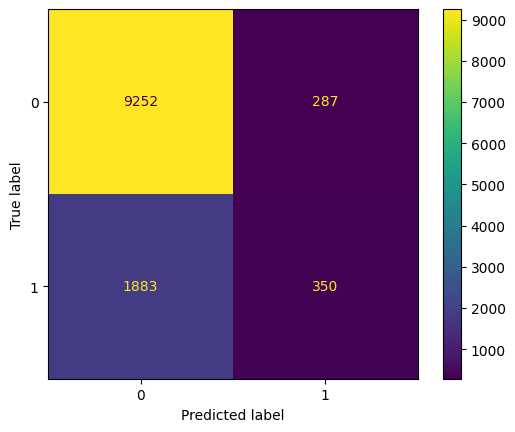

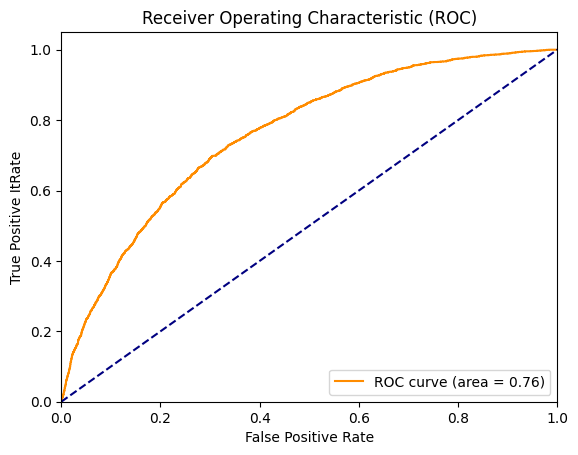

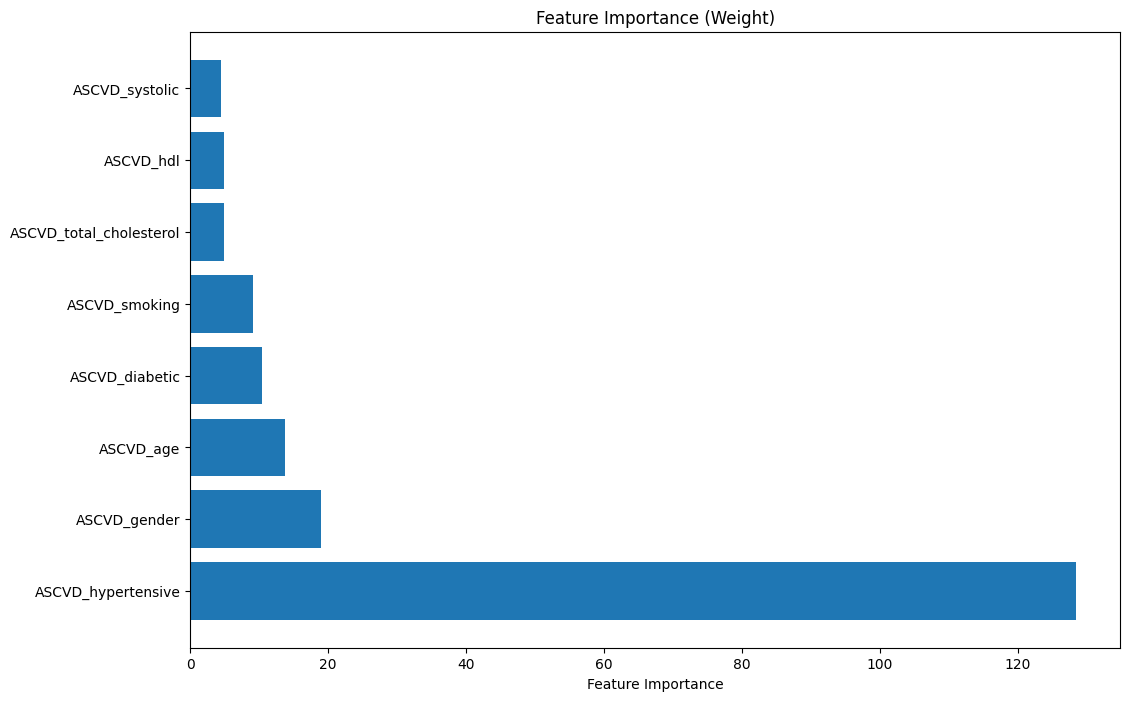

In [15]:
# Assuming 'balanced_df' is your DataFrame and it's already loaded
# 'Heart_Failure' is the target variable

def train_and_evaluate(data, train_features, target, model, test_size=0.2, random_state=42):
    """
    Trains and evaluates a machine learning model.

    Parameters:
        data (DataFrame): The full dataset containing the features and target.
        train_features (list): List of columns to be used as features.
        target (str): Name of the target column.
        model (object): A pre-configured machine learning model.
        test_size (float): Fraction of data to be used as test set.
        random_state (int): Seed used by the random number generator for reproducibility.
    """

    # Data preparation
    X = data[train_features]
    X = data_transform(balanced_df[train_features])
    
    y = data[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # return X_train,y_train
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Output the evaluation
    print("Accuracy:", accuracy)
    print("Classification Report:\n", class_report)

    plotting(X_test, y_test, y_pred, model)
    return model, accuracy, conf_matrix, class_report


# Define your XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    subsample=0.8,
    n_estimators=100,
    learning_rate=0.1,
    seed=42
)

# Define features and target
features = ["ASCVD_age","ASCVD_diabetic","ASCVD_smoking","ASCVD_hdl","ASCVD_hypertensive","ASCVD_systolic","ASCVD_gender","ASCVD_total_cholesterol"]
target = 'Heart_Failure'

model_base, accuracy, conf_matrix, class_report = train_and_evaluate(balanced_df, features, target, model)
feature_importance = model_base.get_booster().get_score(importance_type='gain')  # Change to 'gain' or 'cover' as needed


sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importance_scores = zip(*sorted_importance)

plt.figure(figsize=(12, 8))
plt.barh(features, importance_scores)
plt.xlabel("Feature Importance")
plt.title("Feature Importance (Weight)")
plt.show()

Accuracy: 0.810227658851512
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90      9539
           1       0.00      0.00      0.00      2233

    accuracy                           0.81     11772
   macro avg       0.41      0.50      0.45     11772
weighted avg       0.66      0.81      0.73     11772



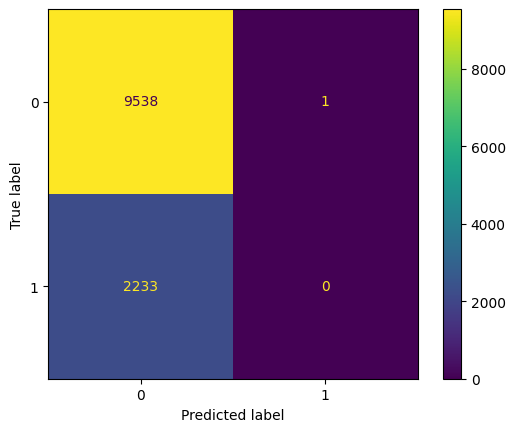

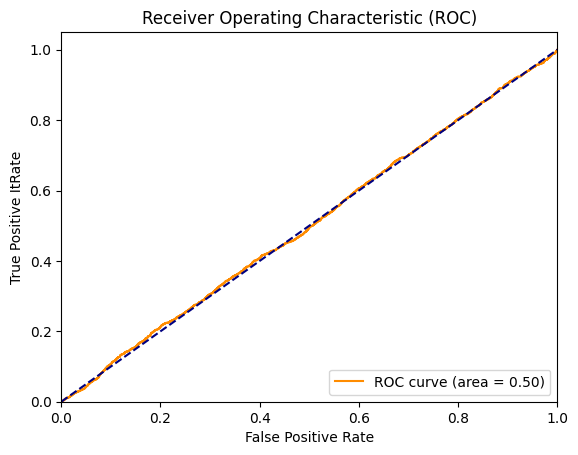

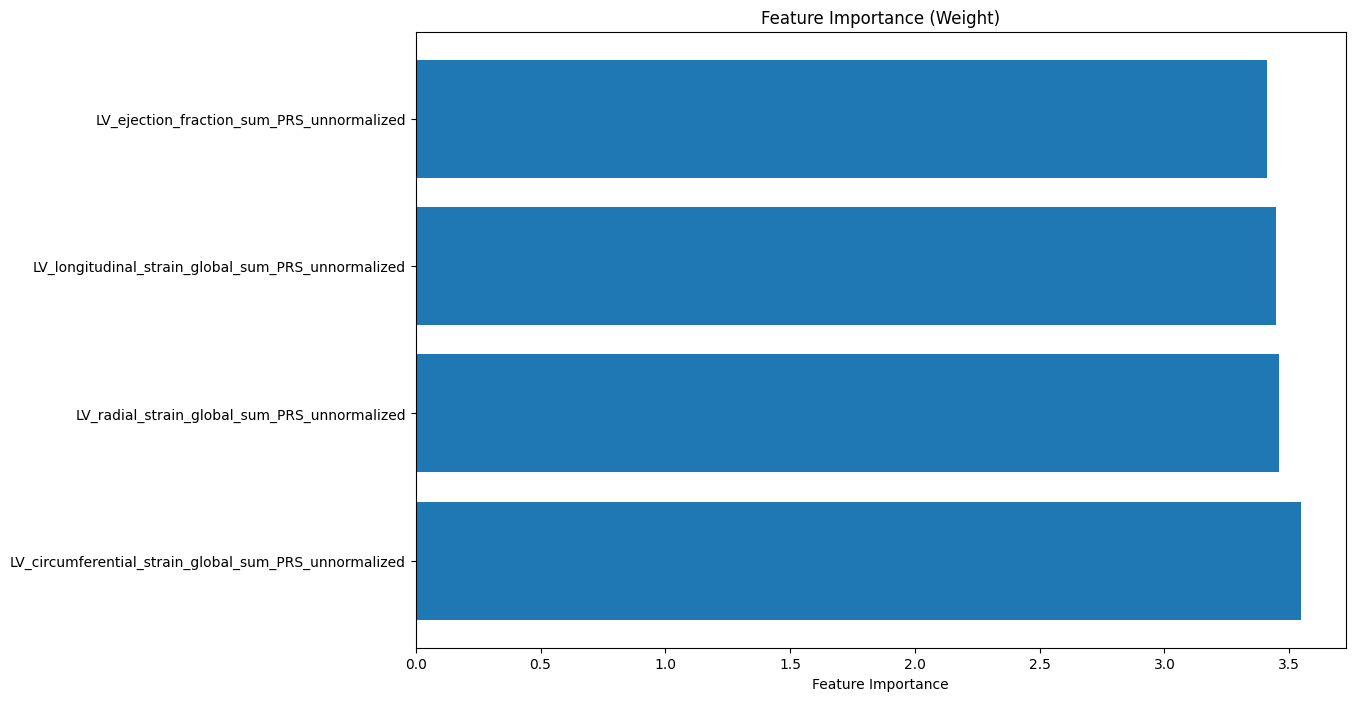

In [94]:
# Define features and target
features = ["LV_circumferential_strain_global_sum_PRS_unnormalized","LV_ejection_fraction_sum_PRS_unnormalized","LV_longitudinal_strain_global_sum_PRS_unnormalized","LV_radial_strain_global_sum_PRS_unnormalized"]
target = 'Heart_Failure'

# Call the function with your data
model_PRS, accuracy, conf_matrix, class_report = train_and_evaluate(balanced_df, features, target, model)
feature_importance = model_PRS.get_booster().get_score(importance_type='gain')  # Change to 'gain' or 'cover' as needed

# For a better view, sort and plot the feature importances
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importance_scores = zip(*sorted_importance)

plt.figure(figsize=(12, 8))
plt.barh(features, importance_scores)
plt.xlabel("Feature Importance")
plt.title("Feature Importance (Weight)")
plt.show()


